# UK National Rail Data EDA Report

The following data and analysis are intended for scheduling prediction purposes. This report details our data cleaning steps and analysis, focusing on the probable causes and patterns of train delays in the UK. It analyzes features including stations, routes, and other relevant factors.

Using Kafka consumer and producer, a data pipeline was run for 1 week, from 7/10/24 - 7/17/24, reading live data from the UK National Rail Data Portal and sending messages for each event, to our PostgreSQL database, hosted on Amazon Web Services. To ensure the pipeline runs consistently across different environments, we packaged the entire pipeline in a Docker container using Docker images.

## Creating a Spark Session 

In [2]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import DecimalType
from credentials import properties

# Create a SparkSession

spark = SparkSession \
    .builder \
    .appName("MySparkApp") \
    .config("spark.jars", "postgresql-42.7.3.jar") \
    .getOrCreate()

## Connecting to AWS & Reading in Data from PostgreSQL

In [3]:
# Connect to AWS Postgres database
# Read in SQL data
df = spark.read \
    .format("jdbc") \
    .option("url", f"jdbc:postgresql://{properties['HOSTNAME']}:{properties['PORT']}/{properties['DBNAME']}") \
    .option("dbtable", "darwin") \
    .option("user", properties['USERNAME']) \
    .option("password", properties['PASS']) \
    .option("driver", "org.postgresql.Driver") \
    .load()

df.printSchema()

# Row count
initial_rows = df.count()
print(f" Rows: {initial_rows}")

# Column count
initial_cols = len(df.columns)
print(f"Columns: {initial_cols}")


root
 |-- route_id: string (nullable = true)
 |-- unique_id: string (nullable = true)
 |-- service_start_date: date (nullable = true)
 |-- update_origin: string (nullable = true)
 |-- train_platform: string (nullable = true)
 |-- working_time_pass: timestamp (nullable = true)
 |-- working_time_arrival: timestamp (nullable = true)
 |-- working_time_departure: timestamp (nullable = true)
 |-- planned_time_arrival: timestamp (nullable = true)
 |-- planned_time_departure: timestamp (nullable = true)
 |-- actual_arrival_time: timestamp (nullable = true)
 |-- actual_departure_time: timestamp (nullable = true)
 |-- platform: string (nullable = true)
 |-- train_length: integer (nullable = true)
 |-- estimated_time: timestamp (nullable = true)
 |-- source: string (nullable = true)
 |-- actual_time: timestamp (nullable = true)
 |-- actual_time_class: string (nullable = true)
 |-- is_delayed_arrival: boolean (nullable = true)
 |-- is_delayed_departure: boolean (nullable = true)
 |-- source_instan

## Read in Data to Pandas

In [4]:
pandas_df = df.toPandas()
pandas_df

,route_id,unique_id,service_start_date,update_origin,train_platform,working_time_pass,working_time_arrival,working_time_departure,planned_time_arrival,planned_time_departure,...,platform,train_length,estimated_time,source,actual_time,actual_time_class,is_delayed_arrival,is_delayed_departure,source_instance,estimated_time_minutes
0,202407087154582,G54582,2024-07-08,TD,CRSHLTN,NaT,1970-01-01 15:48:30,1970-01-01 15:49:30,1970-01-01 15:49:00,1970-01-01 15:49:00,...,1,8.0,NaT,None,NaT,None,False,False,None,NaN
1,202407086735809,C35809,2024-07-08,TD,BRMBRK,NaT,1970-01-01 14:50:00,1970-01-01 14:50:30,1970-01-01 14:50:00,1970-01-01 14:50:00,...,1,NaN,NaT,None,NaT,None,False,False,None,NaN
2,202407086785115,C85115,2024-07-08,TD,SLOUGH,NaT,1970-01-01 14:50:30,1970-01-01 14:51:30,1970-01-01 14:51:00,1970-01-01 14:51:00,...,5,NaN,NaT,None,NaT,None,False,False,None,NaN
3,202407087145471,G45471,2024-07-08,TD,OXFD,NaT,1970-01-01 14:51:30,1970-01-01 14:52:30,1970-01-01 14:52:00,1970-01-01 14:52:00,...,4,NaN,NaT,None,NaT,None,False,False,None,NaN
4,202407087661793,L61793,2024-07-08,TD,BNTFORD,NaT,1970-01-01 14:52:00,1970-01-01 14:53:00,1970-01-01 14:52:00,1970-01-01 14:53:00,...,2,NaN,NaT,None,NaT,None,False,False,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129353,202407176748528,C48528,2024-07-17,CIS,NWPTRTG,NaT,1970-01-01 16:11:00,1970-01-01 16:13:00,1970-01-01 16:11:00,1970-01-01 16:13:00,...,2,NaN,NaT,None,NaT,None,False,False,None,NaN
129354,202407177131427,G31427,2024-07-17,None,CONONLY,NaT,1970-01-01 16:11:00,1970-01-01 16:12:00,1970-01-01 16:11:00,1970-01-01 16:12:00,...,2,4.0,NaT,None,NaT,None,False,False,None,NaN
129355,202407177660736,L60736,2024-07-17,TD,CLPHMJM,NaT,1970-01-01 16:27:00,1970-01-01 16:28:30,1970-01-01 16:27:00,1970-01-01 16:28:00,...,7,NaN,NaT,None,NaT,None,False,False,None,NaN
129356,202407177138743,G38743,2024-07-17,TD,ECROYDN,NaT,1970-01-01 16:21:00,1970-01-01 16:22:00,1970-01-01 16:21:00,1970-01-01 16:22:00,...,6,3.0,NaT,None,NaT,None,False,False,None,NaN


## Check for Duplicate Values, Nulls & Outliers

To ensure quality & accuracy, certain columns containing null values, duplicates, and outliers will be dropped. 

**Nulls**

In [5]:
# Null count for all columns
Dict_Null = {col:df.filter(df[col].isNull()).count() for col in df.columns}
Dict_Null

{'route_id': 0,
 'unique_id': 0,
 'service_start_date': 0,
 'update_origin': 4349,
 'train_platform': 0,
 'working_time_pass': 129358,
 'working_time_arrival': 0,
 'working_time_departure': 0,
 'planned_time_arrival': 8599,
 'planned_time_departure': 8627,
 'actual_arrival_time': 26405,
 'actual_departure_time': 12588,
 'platform': 5766,
 'train_length': 81624,
 'estimated_time': 129358,
 'source': 129358,
 'actual_time': 129358,
 'actual_time_class': 129358,
 'is_delayed_arrival': 0,
 'is_delayed_departure': 0,
 'source_instance': 129358,
 'estimated_time_minutes': 129358}

In [6]:
# Drop columns with too many nulls
df = df.drop('working_time_pass',\
             'estimated_time',\
             'actual_time',\
             'actual_time_class',\
             'source_instance',\
             'estimated_time_minutes',\
             'train_length',\
             'source', \
            'source_instance', \
            'update_origin')

In [7]:
# Drop rows with too many nulls
df = df.dropna(subset='planned_time_departure')
df = df.dropna(subset='planned_time_arrival')

In [8]:
# New null count for all columns
Dict_Null = {col:df.filter(df[col].isNull()).count() for col in df.columns}
Dict_Null

{'route_id': 0,
 'unique_id': 0,
 'service_start_date': 0,
 'train_platform': 0,
 'working_time_arrival': 0,
 'working_time_departure': 0,
 'planned_time_arrival': 0,
 'planned_time_departure': 0,
 'actual_arrival_time': 25679,
 'actual_departure_time': 12275,
 'platform': 2122,
 'is_delayed_arrival': 0,
 'is_delayed_departure': 0}

Dropping null values in actual_arrival_time and actual_departure_time were considered, but trials showed that doing so reduced the accuracy of the future regression model.

**Duplicates**

In [9]:
# Identify duplicate rows
df.groupBy(df.columns)\
    .count()\
    .where(F.col('count') > 1)\
    .select(F.sum('count'))\
    .show()

+----------+
|sum(count)|
+----------+
|     14373|
+----------+



In [10]:
# Drop duplicates
df = df.dropDuplicates()

**Outliers**

In [11]:
from pyspark.sql.types import NumericType

# Define function to remove outliers
def remove_outliers(df, column):
    # Get IQR
    quantiles = df.approxQuantile(column, [0.25, 0.75], 0.05)
    # Check for valid quantities
    if len(quantiles) < 2:
        return df, 0
    Q1 = quantiles[0]
    Q3 = quantiles[1]
    IQR = Q3 - Q1

    # Define lower and upper bounds, return
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df.filter((F.col(column) >= lower_bound) & (F.col(column) <= upper_bound))

# Get all numeric columns and remove outliers
numeric_columns = [x.name for x in df.schema.fields if isinstance(x.dataType, NumericType)]
for column in numeric_columns:
    df = remove_outliers(df, column)

**Calculating Percentage of Rows Dropped**

In [12]:
new_rows = df.count()
rows_dropped = initial_rows - new_rows

new_cols = len(df.columns)
cols_dropped = initial_cols - new_cols

percent_data_dropped = (((rows_dropped*cols_dropped) / (initial_rows*initial_cols)) * 100)
percent_rows_dropped = ((rows_dropped / initial_rows) * 100)

print(f"Current rows: {new_rows}")
print(f"Total rows dropped: {rows_dropped}")
print(f"% of rows dropped: {percent_rows_dropped:.2f}%")
print(f"Percentage of total data dropped: {percent_data_dropped:.2f}%")

Current rows: 112978
Total rows dropped: 16380
% of rows dropped: 12.66%
Percentage of total data dropped: 5.18%


## Creating New Columns/ Feature Engineering
New columns:
- **planned_arrival_hour & planned_dep_hour:** extracting the hour component
- **actual_arrival _hour & actual_dep_hour:** extracting the hour component
- **arrival_time_delayed_by(min):** delay in minutes between the actual and planned arrival times
- **dep_time_delayed_by(min):** delay in minutes between the actual and planned departure times
- **day_of_week:** indicates the day of the week from the service start date


In [13]:
# Create separate columns for date, time, hour
from pyspark.sql.functions import *
import datetime

# Planned arrival hour
df = df.withColumn('planned_arrival_hour', hour(F.col('planned_time_arrival')))

# Planned departure hour
df = df.withColumn('planned_dep_hour', hour(F.col('planned_time_departure')))

# Actual arrival hour
df = df.withColumn('actual_arrival_hour', hour(F.col('actual_arrival_time')))

# Actual departure hour
df = df.withColumn('actual_dep_hour', hour(F.col('actual_departure_time')))

# Calculating delay in minutes
df = df.withColumn('arrival_time_delayed_by(min)', (unix_timestamp("actual_arrival_time") - unix_timestamp('planned_time_arrival'))/60)
df = df.withColumn('dep_time_delayed_by(min)', (unix_timestamp("actual_departure_time") - unix_timestamp('planned_time_departure'))/60)

# Create weekday var
df = df.withColumn('day_of_week', date_format(F.col('service_start_date'), 'EEEE'))

# Filter by arrival time delayed & sort
df.select(F.col('arrival_time_delayed_by(min)')).filter(F.col('arrival_time_delayed_by(min)') > 0).orderBy('arrival_time_delayed_by(min)', ascending=False).show()

+----------------------------+
|arrival_time_delayed_by(min)|
+----------------------------+
|                       145.0|
|                       144.0|
|                       141.0|
|                       141.0|
|                       141.0|
|                       140.0|
|                       139.0|
|                       139.0|
|                       139.0|
|                       139.0|
|                       139.0|
|                       139.0|
|                       138.0|
|                       138.0|
|                       137.0|
|                       137.0|
|                       137.0|
|                       137.0|
|                       136.0|
|                       136.0|
+----------------------------+
only showing top 20 rows



## Merge Data with Rail References


SQL data is merged with RailReferences.csv to idenfity train, station, and geographical information.

In [14]:
# Import RailReferences.csv & merge with SQL data
rail_ref = spark.read.csv('RailReferences.csv', header=True, inferSchema=True)
rail_ref.printSchema()

root
 |-- AtcoCode: string (nullable = true)
 |-- TiplocCode: string (nullable = true)
 |-- CrsCode: string (nullable = true)
 |-- StationName: string (nullable = true)
 |-- StationNameLang: string (nullable = true)
 |-- GridType: string (nullable = true)
 |-- Easting: integer (nullable = true)
 |-- Northing: integer (nullable = true)
 |-- CreationDateTime: timestamp (nullable = true)
 |-- ModificationDateTime: timestamp (nullable = true)
 |-- RevisionNumber: integer (nullable = true)
 |-- Modification: string (nullable = true)



In [15]:
# Merge both DataFrames for Station Name
merged_df = df.join(rail_ref, df['train_platform'] == rail_ref['TiplocCode'], how='left')
merged_df.count()

112978

In [16]:
merged_df.printSchema()

root
 |-- route_id: string (nullable = true)
 |-- unique_id: string (nullable = true)
 |-- service_start_date: date (nullable = true)
 |-- train_platform: string (nullable = true)
 |-- working_time_arrival: timestamp (nullable = true)
 |-- working_time_departure: timestamp (nullable = true)
 |-- planned_time_arrival: timestamp (nullable = true)
 |-- planned_time_departure: timestamp (nullable = true)
 |-- actual_arrival_time: timestamp (nullable = true)
 |-- actual_departure_time: timestamp (nullable = true)
 |-- platform: string (nullable = true)
 |-- is_delayed_arrival: boolean (nullable = true)
 |-- is_delayed_departure: boolean (nullable = true)
 |-- planned_arrival_hour: integer (nullable = true)
 |-- planned_dep_hour: integer (nullable = true)
 |-- actual_arrival_hour: integer (nullable = true)
 |-- actual_dep_hour: integer (nullable = true)
 |-- arrival_time_delayed_by(min): double (nullable = true)
 |-- dep_time_delayed_by(min): double (nullable = true)
 |-- day_of_week: string

## Convert to Pandas for Additional Exploration & Visualization

In [17]:
pandas_df = merged_df.toPandas()

In [18]:
import pandas as pd
# Setting pandas to display all columns 
pd.set_option('display.max_columns', None)

In [19]:
pandas_df

,route_id,unique_id,service_start_date,train_platform,working_time_arrival,working_time_departure,planned_time_arrival,planned_time_departure,actual_arrival_time,actual_departure_time,platform,is_delayed_arrival,is_delayed_departure,planned_arrival_hour,planned_dep_hour,actual_arrival_hour,actual_dep_hour,arrival_time_delayed_by(min),dep_time_delayed_by(min),day_of_week,AtcoCode,TiplocCode,CrsCode,StationName,StationNameLang,GridType,Easting,Northing,CreationDateTime,ModificationDateTime,RevisionNumber,Modification
0,202407087150990,G50990,2024-07-08,TULSEH,1970-01-01 15:39:00,1970-01-01 15:40:30,1970-01-01 15:39:00,1970-01-01 15:40:00,1970-01-01 15:44:00,1970-01-01 15:45:00,2,False,False,15,15,15.0,15.0,5.0,5.0,Monday,9100TULSEH,TULSEH,TUH,Tulse Hill Rail Station,None,U,531800.0,172910.0,2003-11-04,2010-05-27 19:04:08,2.0,rev
1,202407088093163,P93163,2024-07-08,BROCKLY,1970-01-01 17:47:00,1970-01-01 17:47:30,1970-01-01 17:47:00,1970-01-01 17:47:00,1970-01-01 17:47:00,1970-01-01 17:48:00,2,False,False,17,17,17.0,17.0,0.0,1.0,Monday,9100BROCKLY,BROCKLY,BCY,Brockley Rail Station,None,U,536420.0,175790.0,2003-11-04,2010-05-14 17:36:24,2.0,rev
2,202407086704542,C04542,2024-07-08,HRTLEPL,1970-01-01 22:23:00,1970-01-01 22:26:00,1970-01-01 22:23:00,1970-01-01 22:26:00,1970-01-01 22:48:00,1970-01-01 22:49:00,2,False,False,22,22,22.0,22.0,25.0,23.0,Monday,9100HRTLEPL,HRTLEPL,HPL,Hartlepool Rail Station,None,U,451200.0,532700.0,2003-11-04,2006-09-18 18:24:34,1.0,rev
3,202407086776190,C76190,2024-07-08,BHAMINT,1970-01-01 18:45:00,1970-01-01 18:46:00,1970-01-01 18:45:00,1970-01-01 18:46:00,1970-01-01 18:45:00,1970-01-01 18:46:00,4,False,False,18,18,18.0,18.0,0.0,0.0,Monday,9100BHAMINT,BHAMINT,BHI,Birmingham International Rail Station,None,U,418728.0,283685.0,2003-11-04,2006-09-18 18:24:34,1.0,rev
4,202407088078559,P78559,2024-07-08,SPFD,1970-01-01 22:59:30,1970-01-01 23:00:30,1970-01-01 23:00:00,1970-01-01 23:00:00,1970-01-01 23:02:00,1970-01-01 23:03:00,2,False,False,23,23,23.0,23.0,2.0,3.0,Monday,9100SPFD,SPFD,SPF,Springfield Rail Station,None,U,334960.0,711890.0,2003-11-04,2006-09-18 18:24:34,1.0,rev
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112973,202407178094974,P94974,2024-07-17,EDPK,1970-01-01 16:03:30,1970-01-01 16:04:00,1970-01-01 16:04:00,1970-01-01 16:04:00,1970-01-01 16:05:00,1970-01-01 16:05:00,1,False,False,16,16,16.0,16.0,1.0,1.0,Wednesday,9100EDPK,EDPK,EDN,Eden Park Rail Station,None,U,537420.0,167520.0,2003-11-04,2010-09-06 16:58:37,3.0,rev
112974,202407176784894,C84894,2024-07-17,MDNHEAD,1970-01-01 15:55:00,1970-01-01 15:56:00,1970-01-01 15:55:00,1970-01-01 15:56:00,NaT,1970-01-01 15:56:00,3,False,False,15,15,NaN,15.0,NaN,0.0,Wednesday,9100MDNHEAD,MDNHEAD,MAI,Maidenhead Rail Station,None,U,488725.0,180745.0,2005-04-21,2006-09-18 18:24:34,1.0,rev
112975,202407176760257,C60257,2024-07-17,DRBY,1970-01-01 16:07:00,1970-01-01 16:09:00,1970-01-01 16:07:00,1970-01-01 16:09:00,1970-01-01 16:09:00,1970-01-01 16:10:00,6,False,False,16,16,16.0,16.0,2.0,1.0,Wednesday,9100DRBY,DRBY,DBY,Derby Rail Station,None,U,436182.0,335593.0,2003-11-04,2013-11-12 18:24:34,1.0,rev
112976,202407176735843,C35843,2024-07-17,BRKNHDN,1970-01-01 15:46:30,1970-01-01 15:47:30,1970-01-01 15:47:00,1970-01-01 15:47:00,NaT,NaT,3,False,False,15,15,NaN,NaN,NaN,NaN,Wednesday,9100BRKNHDN,BRKNHDN,BKN,Birkenhead North Rail Station,None,U,329790.0,390256.0,2003-11-04,2008-11-12 18:12:33,2.0,rev


## Adjusting StationName Column for Better Readibility

With nulls in the StationName column, we filled those with their respective train platforms

In [20]:
# Fill null Station Names with its respective Train Platform
pandas_df['StationName'] = pandas_df['StationName'].fillna(pandas_df['train_platform'])

Each station's name read "Rail Station" at the end. Those were eliminated for redundency and readibility.

In [21]:
# Eliminate "Rail Station" for better readibility
pandas_df['StationName'] = pandas_df['StationName'].str.replace(' Rail Station', '')


## Creating Latitude & Longitude Columns

For further analysis with regions, the Easting & Northing columns were converted to latitude and longitude, where we can analyze train delays at precise geographical locations, visualize patterns, and identify regions where trains might be delayed.

In [22]:
# Drop nulls before conversion
pandas_df = pandas_df.dropna(subset=['Easting', 'Northing'])

In [ ]:
from pyproj import Proj, Transformer

# Define data from the National British Grid
# British National Grid (EPSG:27700)
bng = 'epsg:27700'
# WGS84 (EPSG:4326)
wgs84 = 'epsg:4326'

# Define the transformer for converting BNG to WGS84
transformer = Transformer.from_crs(bng, wgs84)

# Function to convert Easting & Northing to latitude & longitude
def convert_to_latlong(easting, northing):
    longitude, latitude = transformer.transform(easting, northing)
    return longitude, latitude

# Create Latitude & Longitude columns in the DataFrame
pandas_df[['Latitude', 'Longitude']] = pandas_df.apply(lambda row: convert_to_latlong(row['Easting'], row['Northing']),\
                                         axis=1,\
                                         result_type='expand')

In [24]:
pandas_df

,route_id,unique_id,service_start_date,train_platform,working_time_arrival,working_time_departure,planned_time_arrival,planned_time_departure,actual_arrival_time,actual_departure_time,platform,is_delayed_arrival,is_delayed_departure,planned_arrival_hour,planned_dep_hour,actual_arrival_hour,actual_dep_hour,arrival_time_delayed_by(min),dep_time_delayed_by(min),day_of_week,AtcoCode,TiplocCode,CrsCode,StationName,StationNameLang,GridType,Easting,Northing,CreationDateTime,ModificationDateTime,RevisionNumber,Modification,Latitude,Longitude
0,202407087150990,G50990,2024-07-08,TULSEH,1970-01-01 15:39:00,1970-01-01 15:40:30,1970-01-01 15:39:00,1970-01-01 15:40:00,1970-01-01 15:44:00,1970-01-01 15:45:00,2,False,False,15,15,15.0,15.0,5.0,5.0,Monday,9100TULSEH,TULSEH,TUH,Tulse Hill,None,U,531800.0,172910.0,2003-11-04,2010-05-27 19:04:08,2.0,rev,51.439859,-0.105077
1,202407088093163,P93163,2024-07-08,BROCKLY,1970-01-01 17:47:00,1970-01-01 17:47:30,1970-01-01 17:47:00,1970-01-01 17:47:00,1970-01-01 17:47:00,1970-01-01 17:48:00,2,False,False,17,17,17.0,17.0,0.0,1.0,Monday,9100BROCKLY,BROCKLY,BCY,Brockley,None,U,536420.0,175790.0,2003-11-04,2010-05-14 17:36:24,2.0,rev,51.464647,-0.037537
2,202407086704542,C04542,2024-07-08,HRTLEPL,1970-01-01 22:23:00,1970-01-01 22:26:00,1970-01-01 22:23:00,1970-01-01 22:26:00,1970-01-01 22:48:00,1970-01-01 22:49:00,2,False,False,22,22,22.0,22.0,25.0,23.0,Monday,9100HRTLEPL,HRTLEPL,HPL,Hartlepool,None,U,451200.0,532700.0,2003-11-04,2006-09-18 18:24:34,1.0,rev,54.686754,-1.207316
3,202407086776190,C76190,2024-07-08,BHAMINT,1970-01-01 18:45:00,1970-01-01 18:46:00,1970-01-01 18:45:00,1970-01-01 18:46:00,1970-01-01 18:45:00,1970-01-01 18:46:00,4,False,False,18,18,18.0,18.0,0.0,0.0,Monday,9100BHAMINT,BHAMINT,BHI,Birmingham International,None,U,418728.0,283685.0,2003-11-04,2006-09-18 18:24:34,1.0,rev,52.450805,-1.725857
4,202407088078559,P78559,2024-07-08,SPFD,1970-01-01 22:59:30,1970-01-01 23:00:30,1970-01-01 23:00:00,1970-01-01 23:00:00,1970-01-01 23:02:00,1970-01-01 23:03:00,2,False,False,23,23,23.0,23.0,2.0,3.0,Monday,9100SPFD,SPFD,SPF,Springfield,None,U,334960.0,711890.0,2003-11-04,2006-09-18 18:24:34,1.0,rev,56.294969,-3.052448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112973,202407178094974,P94974,2024-07-17,EDPK,1970-01-01 16:03:30,1970-01-01 16:04:00,1970-01-01 16:04:00,1970-01-01 16:04:00,1970-01-01 16:05:00,1970-01-01 16:05:00,1,False,False,16,16,16.0,16.0,1.0,1.0,Wednesday,9100EDPK,EDPK,EDN,Eden Park,None,U,537420.0,167520.0,2003-11-04,2010-09-06 16:58:37,3.0,rev,51.390089,-0.026355
112974,202407176784894,C84894,2024-07-17,MDNHEAD,1970-01-01 15:55:00,1970-01-01 15:56:00,1970-01-01 15:55:00,1970-01-01 15:56:00,NaT,1970-01-01 15:56:00,3,False,False,15,15,NaN,15.0,NaN,0.0,Wednesday,9100MDNHEAD,MDNHEAD,MAI,Maidenhead,None,U,488725.0,180745.0,2005-04-21,2006-09-18 18:24:34,1.0,rev,51.518667,-0.722660
112975,202407176760257,C60257,2024-07-17,DRBY,1970-01-01 16:07:00,1970-01-01 16:09:00,1970-01-01 16:07:00,1970-01-01 16:09:00,1970-01-01 16:09:00,1970-01-01 16:10:00,6,False,False,16,16,16.0,16.0,2.0,1.0,Wednesday,9100DRBY,DRBY,DBY,Derby,None,U,436182.0,335593.0,2003-11-04,2013-11-12 18:24:34,1.0,rev,52.916546,-1.463355
112976,202407176735843,C35843,2024-07-17,BRKNHDN,1970-01-01 15:46:30,1970-01-01 15:47:30,1970-01-01 15:47:00,1970-01-01 15:47:00,NaT,NaT,3,False,False,15,15,NaN,NaN,NaN,NaN,Wednesday,9100BRKNHDN,BRKNHDN,BKN,Birkenhead North,None,U,329790.0,390256.0,2003-11-04,2008-11-12 18:12:33,2.0,rev,53.404433,-3.057533


**Categorizing Longitude & Latitude Columns into Regions**

Using the calculated latitude and longitude values, we catoergorized them into respective geogrpahical regions

In [ ]:
# Create regions: Northern, Southern, Eastern, Western, & Central
northern = 54.5  # Approx. above Yorkshire
southern = 51.0  # Approx. below London
eastern = -0.5   # East of the Prime Meridian
western = -3.0   # West of the Prime Meridian
# All else will return as Central

# Function to categorize regions
def categorize_region(latitude, longitude):
    if latitude >= northern:
        return 'Northern'
    elif latitude < southern:
        return 'Southern'
    elif longitude >= eastern:
        return 'Eastern'
    elif longitude < western:
        return 'Western'
    else:
        return 'Central'

# Create new column for regions
pandas_df['Region'] =pandas_df.apply(lambda row: categorize_region(row['Latitude'], row['Longitude']), axis=1)


In [26]:
pandas_df.head(10)

,route_id,unique_id,service_start_date,train_platform,working_time_arrival,working_time_departure,planned_time_arrival,planned_time_departure,actual_arrival_time,actual_departure_time,platform,is_delayed_arrival,is_delayed_departure,planned_arrival_hour,planned_dep_hour,actual_arrival_hour,actual_dep_hour,arrival_time_delayed_by(min),dep_time_delayed_by(min),day_of_week,AtcoCode,TiplocCode,CrsCode,StationName,StationNameLang,GridType,Easting,Northing,CreationDateTime,ModificationDateTime,RevisionNumber,Modification,Latitude,Longitude,Region
0,202407087150990,G50990,2024-07-08,TULSEH,1970-01-01 15:39:00,1970-01-01 15:40:30,1970-01-01 15:39:00,1970-01-01 15:40:00,1970-01-01 15:44:00,1970-01-01 15:45:00,2,False,False,15,15,15.0,15.0,5.0,5.0,Monday,9100TULSEH,TULSEH,TUH,Tulse Hill,None,U,531800.0,172910.0,2003-11-04,2010-05-27 19:04:08,2.0,rev,51.439859,-0.105077,Eastern
1,202407088093163,P93163,2024-07-08,BROCKLY,1970-01-01 17:47:00,1970-01-01 17:47:30,1970-01-01 17:47:00,1970-01-01 17:47:00,1970-01-01 17:47:00,1970-01-01 17:48:00,2,False,False,17,17,17.0,17.0,0.0,1.0,Monday,9100BROCKLY,BROCKLY,BCY,Brockley,None,U,536420.0,175790.0,2003-11-04,2010-05-14 17:36:24,2.0,rev,51.464647,-0.037537,Eastern
2,202407086704542,C04542,2024-07-08,HRTLEPL,1970-01-01 22:23:00,1970-01-01 22:26:00,1970-01-01 22:23:00,1970-01-01 22:26:00,1970-01-01 22:48:00,1970-01-01 22:49:00,2,False,False,22,22,22.0,22.0,25.0,23.0,Monday,9100HRTLEPL,HRTLEPL,HPL,Hartlepool,None,U,451200.0,532700.0,2003-11-04,2006-09-18 18:24:34,1.0,rev,54.686754,-1.207316,Northern
3,202407086776190,C76190,2024-07-08,BHAMINT,1970-01-01 18:45:00,1970-01-01 18:46:00,1970-01-01 18:45:00,1970-01-01 18:46:00,1970-01-01 18:45:00,1970-01-01 18:46:00,4,False,False,18,18,18.0,18.0,0.0,0.0,Monday,9100BHAMINT,BHAMINT,BHI,Birmingham International,None,U,418728.0,283685.0,2003-11-04,2006-09-18 18:24:34,1.0,rev,52.450805,-1.725857,Central
4,202407088078559,P78559,2024-07-08,SPFD,1970-01-01 22:59:30,1970-01-01 23:00:30,1970-01-01 23:00:00,1970-01-01 23:00:00,1970-01-01 23:02:00,1970-01-01 23:03:00,2,False,False,23,23,23.0,23.0,2.0,3.0,Monday,9100SPFD,SPFD,SPF,Springfield,None,U,334960.0,711890.0,2003-11-04,2006-09-18 18:24:34,1.0,rev,56.294969,-3.052448,Northern
5,202407086779687,C79687,2024-07-08,CHLTNHM,1970-01-01 19:27:00,1970-01-01 19:29:00,1970-01-01 19:27:00,1970-01-01 19:29:00,1970-01-01 19:27:00,1970-01-01 19:29:00,1,False,False,19,19,19.0,19.0,0.0,0.0,Monday,9100CHLTNHM,CHLTNHM,CNM,Cheltenham Spa,None,U,393242.0,222099.0,2003-11-04,2006-09-18 18:24:34,1.0,rev,51.897396,-2.099620,Central
6,202407088081172,P81172,2024-07-08,HAYMRKT,1970-01-01 22:08:30,1970-01-01 22:09:30,1970-01-01 22:09:00,1970-01-01 22:09:00,1970-01-01 22:10:00,1970-01-01 22:11:00,2,False,False,22,22,22.0,22.0,1.0,2.0,Monday,9100HAYMRKT,HAYMRKT,HYM,Haymarket,None,U,324000.0,673200.0,2003-11-04,2006-09-18 18:24:34,1.0,rev,55.945806,-3.218449,Northern
7,202407088901031,Y01031,2024-07-08,FAREHAM,1970-01-01 22:52:30,1970-01-01 22:53:30,1970-01-01 22:53:00,1970-01-01 22:53:00,1970-01-01 22:53:00,1970-01-01 22:53:00,3,False,False,22,22,22.0,22.0,0.0,0.0,Monday,9100FAREHAM,FAREHAM,FRM,Fareham,None,U,456971.0,106257.0,2003-11-04,2007-02-13 17:06:21,4.0,rev,50.853032,-1.192037,Southern
8,202407086717220,C17220,2024-07-08,KENSLG,1970-01-01 17:03:00,1970-01-01 17:03:30,1970-01-01 17:03:00,1970-01-01 17:03:00,1970-01-01 17:03:00,1970-01-01 17:03:00,1,False,False,17,17,17.0,17.0,0.0,0.0,Monday,9100KENSLG,KENSLG,KNL,Kensal Green,None,U,523215.0,182785.0,2003-11-04,2010-05-14 17:37:23,2.0,rev,51.530539,-0.225088,Eastern
9,202407088097407,P97407,2024-07-08,MSTONEE,1970-01-01 17:24:30,1970-01-01 17:26:00,1970-01-01 17:25:00,1970-01-01 17:26:00,1970-01-01 17:25:00,1970-01-01 17:26:00,2,False,False,17,17,17.0,17.0,0.0,0.0,Monday,9100MSTONEE,MSTONEE,MDE,Maidstone East,None,U,575949.0,156206.0,2005-04-21,2006-11-24 15:29:01,2.0,rev,51.277828,0.521295,Eastern


## Describe/ Explore Data

After cleaning the data, the following Data Dictionary defines features that will be analyzed:

**Data Dictionary**
- route_id: The unique identifier for each train route.
- unique_id: The unique identifier for each train
- planned_time_arrival: The officially planned time for the train to arrive at a station. This could be the public-facing scheduled time.
- planned_time_departure: The officially planned time for the train to depart from a station. This could be the public-facing scheduled time.
- platform: The platform number at the station where the train arrives and departs.
- actual_arrival_time: The actual time when the train arrived at a station.
- actual_departure_time: The actual time when the train departed from a station.
- is_delayed_arrival: A boolean flag indicating whether the train arrived late
- is_delayed_departure: A boolean flag indicating whether the train departed late from a station.
- arrival_time_delayed_by(min): Time in mintues the train is delayed arriving.
- dep_time_delayed_by(min): Time in mintues the train is delayed departing.
- day_of_week: The day of the week a train is running.
- latitude: Latitude train coordinates.
- longitude: Longitute train coordinates.
- reagion: Region of the UK the latitude & longitude cooridates correlate to.

## Create a Delayed DataFrame ##

delayed_df only contains information about delayed trains, rather than pandas_df, which shows data for all trains.

In [27]:
# Pull respective cvolumns from pandas_df

delayed_df = pandas_df[['route_id', 'unique_id', 'train_platform', 'StationName', 'day_of_week', 'planned_arrival_hour', 'is_delayed_arrival', 'arrival_time_delayed_by(min)', 'is_delayed_departure', 'planned_dep_hour', 'dep_time_delayed_by(min)', 'actual_arrival_time', 'actual_arrival_hour', 'actual_dep_hour', 'actual_departure_time', 'Longitude','Latitude','Region']]
delayed_df = delayed_df[delayed_df['is_delayed_departure'] == True]

In [28]:
# Change date time formats

delayed_df['actual_arrival_time'] = pd.to_datetime(delayed_df['actual_arrival_time'], format='%H:%M:%S').dt.time
delayed_df['actual_departure_time'] = pd.to_datetime(delayed_df['actual_departure_time'], format='%H:%M:%S').dt.time
delayed_df

,route_id,unique_id,train_platform,StationName,day_of_week,planned_arrival_hour,is_delayed_arrival,arrival_time_delayed_by(min),is_delayed_departure,planned_dep_hour,dep_time_delayed_by(min),actual_arrival_time,actual_arrival_hour,actual_dep_hour,actual_departure_time,Longitude,Latitude,Region
13,202407086731697,C31697,WRGTNBQ,Warrington Bank Quay,Monday,23,True,19.0,True,23,18.0,23:21:00,23.0,23.0,23:22:00,-2.602364,53.386007,Central
14,202407087138854,G38854,POLGATE,Polegate,Monday,22,True,9.0,True,22,9.0,22:48:00,22.0,22.0,22:48:00,0.245140,50.821244,Southern
38,202407098097805,P97805,HTHRGRN,Hither Green,Tuesday,15,True,10.0,True,15,10.0,15:48:00,15.0,15.0,15:48:00,-0.000944,51.452024,Eastern
41,202407096718872,C18872,POLMONT,Polmont,Tuesday,17,True,6.0,True,17,6.0,17:41:00,17.0,17.0,17:41:00,-3.714973,55.984736,Northern
64,202407097154341,G54341,GNHT,Greenhithe for Bluewater,Tuesday,19,True,11.0,True,19,12.0,19:47:00,19.0,19.0,19:48:00,0.280290,51.450370,Eastern
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112777,202407157136502,G36502,BRADIN,Bradford Interchange,Monday,16,False,NaN,True,16,31.0,NaT,NaN,16.0,16:39:00,-1.749596,53.791074,Central
112778,202407157136527,G36527,ACRNGTN,Accrington,Monday,20,True,13.0,True,20,13.0,20:24:00,20.0,20.0,20:25:00,-2.369548,53.752970,Central
112781,202407156734939,C34939,RYEE,Rye,Monday,16,False,NaN,True,16,9.0,NaT,NaN,16.0,16:57:00,0.730695,50.952368,Southern
112793,202407156738280,C38280,WMBYDC,Wembley Central,Monday,18,True,121.0,True,18,122.0,20:42:00,20.0,20.0,20:43:00,-0.296418,51.552323,Eastern


# Data Analytics

Please note, no data has been collected for Saturday

## Analysis 1
## During Which Hour and Day Are Trains Most Frequently Delayed?

First is a visualization of train departures per hour. Understanding this frequency helps identify peak times, optimize schedules, allocate resources efficiently, and plan maintenance to minimize disruptions.

**Train Frequency by Hour**

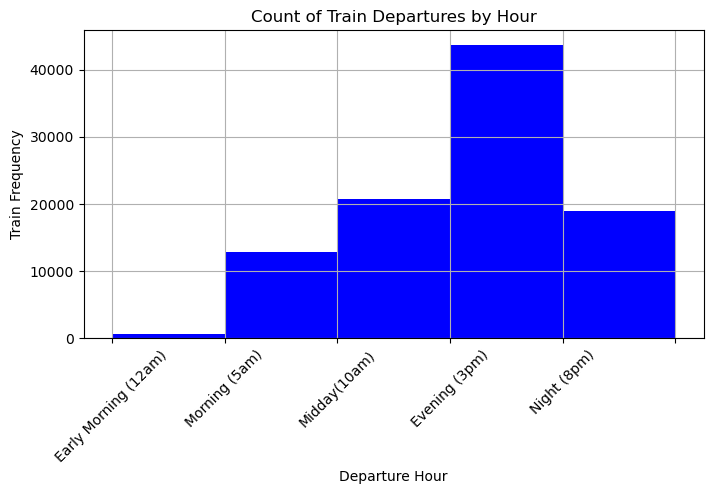

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group departure hours by time of day
bins = [0, 5, 10, 15, 20, 25]
labels = ['Early Morning (12am)', 'Morning (5am)', 'Midday(10am)', 'Evening (3pm)', 'Night (8pm)', ' ']

plt.figure(figsize=(8,4))
plt.hist(pandas_df['actual_dep_hour'], bins=bins, color='blue')
plt.title('Count of Train Departures by Hour')
plt.xlabel('Departure Hour')
plt.ylabel('Train Frequency')
plt.xticks(bins, labels, rotation=45)

plt.grid()
plt.show()

Train departures are most frequent during the evening (3pm-7pm). This increased volume of departures during these times could potentially contribute to a higher likelihood of delays. 

## Delays by Day of Week

Categorizing delays by the day of the week allows us to determine if delays are more frequent on certain days or if specific days consistently experience higher delays. Such information can be useful for future scheduling purposes, such as adding more buffer time to mitigate delays or increasing resources, such as the number of trains running and the availability of staff and maintenance workers.

**Creating a Weekday DataFrame**

In [ ]:
Using the delayed_df, weekday_df identifies the average delay times by day for relevant features 

import pandas as pd

# Grouping delayed data by day of the week and calculating the mean for numeric columns
weekday_df = delayed_df.groupby('day_of_week').mean(numeric_only=True).reset_index()

# Defining the order of the days of the week
days_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

# Creating a categorical column to ensure the correct order of the days
weekday_df['day'] = pd.Categorical(weekday_df['day_of_week'], categories=days_order, ordered=True)

# Sort DataFrame by 'day' column
weekday_df = weekday_df.sort_values('day') 
weekday_df

**Day of Week Distribution**

Visualize the daily distribution of all and delayed departures *noting no data has been collected for Saturday 

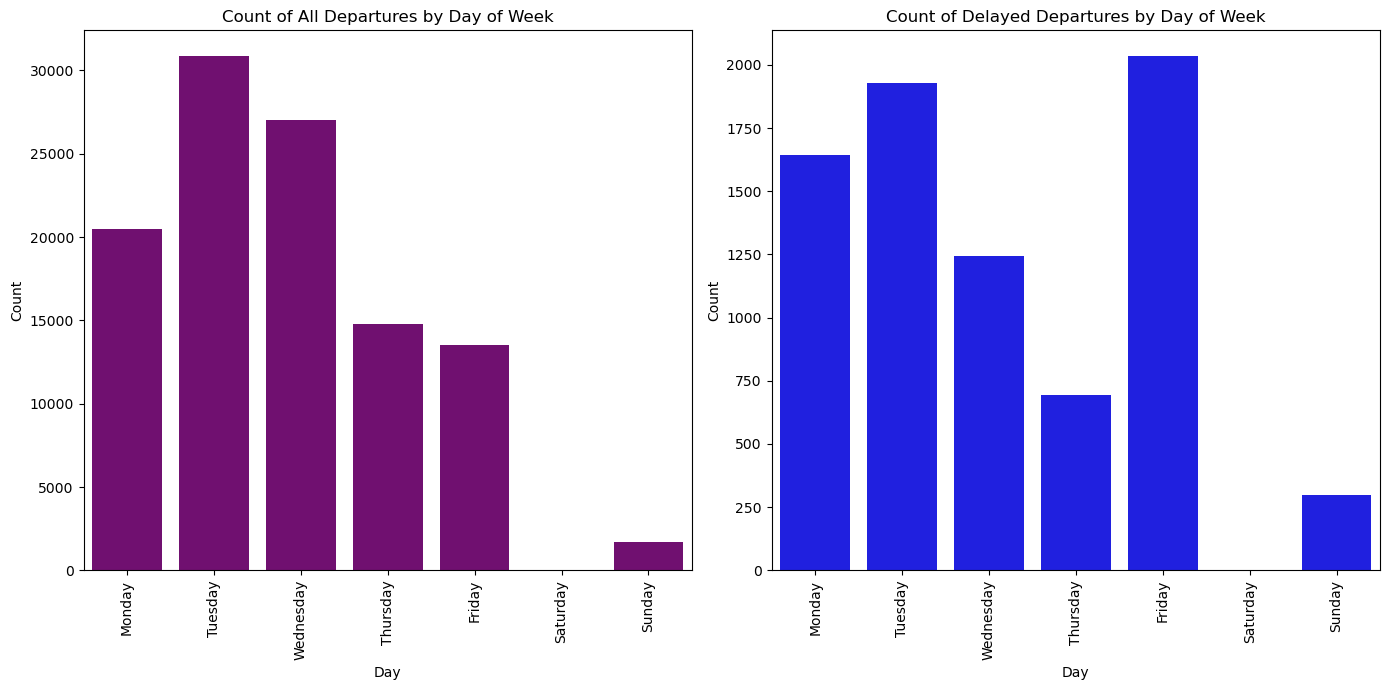

In [31]:
plt.figure(figsize=(14,7))

# Distribution of all trains per day
plt.subplot(1, 2, 1)
day_dist = pandas_df['day_of_week'].value_counts().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
sns.barplot(x=day_dist.index, y=day_dist.values, color='purple')
plt.title('Count of All Departures by Day of Week')
plt.xlabel('Day')
plt.ylabel('Count')
plt.xticks(rotation=90)

# Delayed trains by day of week
plt.subplot(1, 2, 2)
delay_day_dist = delayed_df['day_of_week'].value_counts().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
sns.barplot(x=delay_day_dist.index, y=delay_day_dist.values, color='blue')
plt.title('Count of Delayed Departures by Day of Week')
plt.xlabel('Day')
plt.ylabel('Count')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

**High Train Count and High Delays:**
- Tuesday: While Tuesday has the highest number of departures, it also has a significant number of delays, though not the highest.
- Monday: Shows a high count of departures and a corresponding high count of delays.
  
**High Delays on Lower Train Count Days:**
- Friday: Despite having fewer departures than Tuesday and Wednesday, Friday has the highest number of delays, suggesting specific factors on Fridays contribute to more frequent delays, such as the end-of-week rush

Without sufficient data for Saturday, it is anticipated that the train frequency and delays are be similar to Friday evening's statistics due to evening events. 

## Delays by Departure hour & Day of Week

Visualize the frequency of delayed train departures categorized by the time of day and day of the week

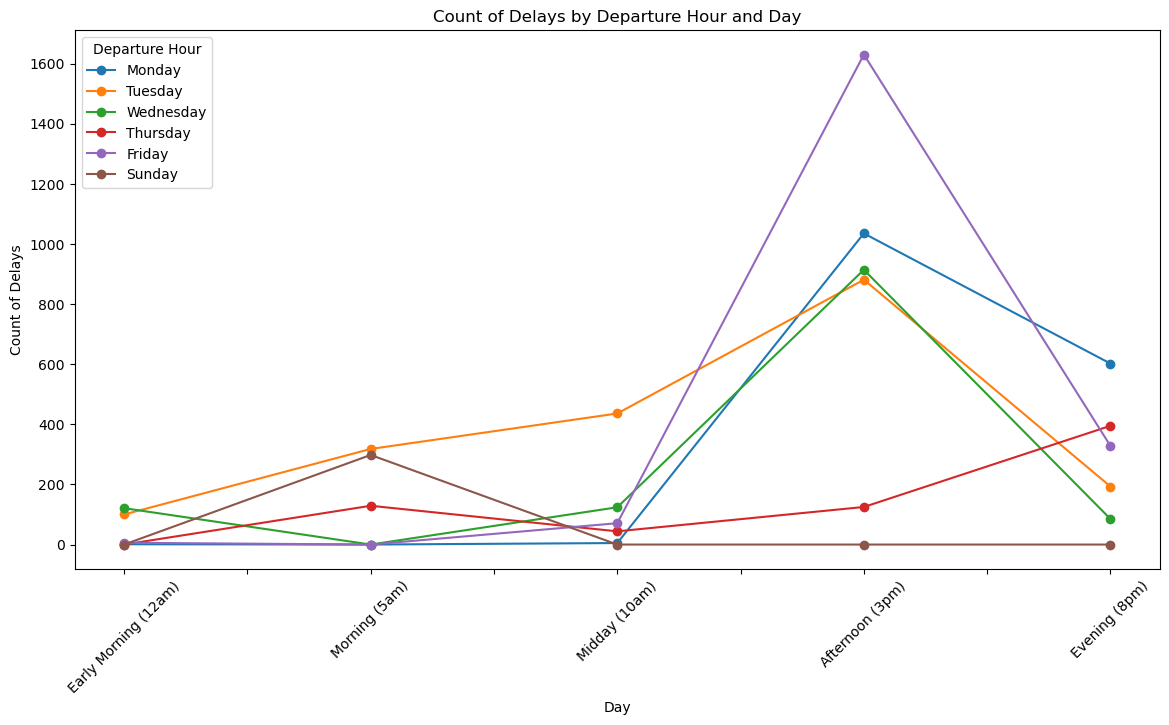

In [32]:
# Define bins and labels for departure hours
bins = [0, 5, 10, 15, 20, 25]
labels = ['Early Morning (12am)', 'Morning (5am)', 'Midday (10am)', 'Afternoon (3pm)', 'Evening (8pm)']

# Create a new column for departure hour categories
delayed_df['dep_hour_category'] = pd.cut(delayed_df['actual_dep_hour'], bins=bins, labels=labels, right=False)

# Order days
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Sunday']

# Define days as categorical
delayed_df['day_of_week'] = pd.Categorical(delayed_df['day_of_week'], categories=days_order, ordered=True)

# Group by day of week and dep_hour_category to get the count of delays
grouped_data = delayed_df.groupby(['dep_hour_category', 'day_of_week']).size().unstack(fill_value=0)


grouped_data.plot(kind='line', figsize=(14, 7), marker='o')
plt.title('Count of Delays by Departure Hour and Day')
plt.xlabel('Day')
plt.ylabel('Count of Delays')
plt.xticks(rotation=45)
plt.legend(title='Departure Hour', loc='upper left')

plt.show()


## Analysis 1 Conclusion

**Train departures**: Train departures are most frequent in the evenings

Why departures are more frequent in the evenings:
- *Evening rush hour*: many workers commute home in the evenings between 4-7pm
- *Worker flexibility*: workers in industries with night shifts (like healthcare, hospitality, and manufacturing) may require a late night train, or even early morning
- *Evening events*: social events, such as dining, concerts, movies, and happy hour are popular evening activities

Why train departures may be less frequent in the mornings:
- Lack of demand
- Work schedules might offer more arrival flexibility in the mornings 
- Maintenance activities are often scheduled for early mornings when fewer trains are running

**Friday Delays**: Trains experience the most frequent delays on Friday afternoons (3pm-8pm) possibly due to an increase of passengers, as many people travel for the weekend, return from business trips, or commute from work, coinciding with already peak travel hours
  
Trains run most frequently on Monday, Tuesday, and Wednesday, with most delays occurring on Monday, Tuesday, and Friday. Sundays consistently show the least number of delays and trains running, indicating lower demand. This data can be used to predict the day and hour delays may be frequent.

## Analysis 2
## Do Train Cancellations Correlate with Departure Hour?

Calculating the number of train cancellations can help us understand the data distribution better. Here, NaT values in the arrivals and departure columns were interpreted as "not a time," indicating a possible cancellation.

**Cancellation % of All Trains**

In [33]:
# Calculate the number of cancellations
cancellations = pandas_df[pandas_df['actual_arrival_time'].isna() | pandas_df['actual_departure_time'].isna()]
num_cancellations = len(cancellations)
print(f"Number of cancellations: {num_cancellations}")

# Calculate the total number of planned departures
total_planned = len(pandas_df)
print(f"Total number of planned departures: {total_planned}")

# Calculate the cancellation rate
cancellation_rate = (num_cancellations / total_planned) * 100
print(f"Cancellation rate: {cancellation_rate:.2f}%")

Number of cancellations: 23900
Total number of planned departures: 108374
Cancellation rate: 22.05%


**Cancellation % of Delayed Trains**

In [34]:
# Delayed trains that get cancelled
delay_cancellations = delayed_df[delayed_df['actual_arrival_time'].isna() | delayed_df['actual_departure_time'].isna()]
delay_num_cancellations = len(delay_cancellations)
print(f"Number of delayed cancellations: {delay_num_cancellations}")

# Calculate the total number of planned departures
delay_total_planned = len(delayed_df)
print(f"Total number of planned delayed departures: {delay_total_planned}")

# Calculate the cancellation rate
delay_cancellation_rate = (delay_num_cancellations / delay_total_planned) * 100
print(f"If a train is delayed, there is a {delay_cancellation_rate:.2f}% chance of cancellation")

Number of delayed cancellations: 208
Total number of planned delayed departures: 7841
If a train is delayed, there is a 2.65% chance of cancellation


Due to the unlikelihood of delayed trains being canceled, pandas_df will be used to analyze all cancellations.

**Train Cancellation Visuals**

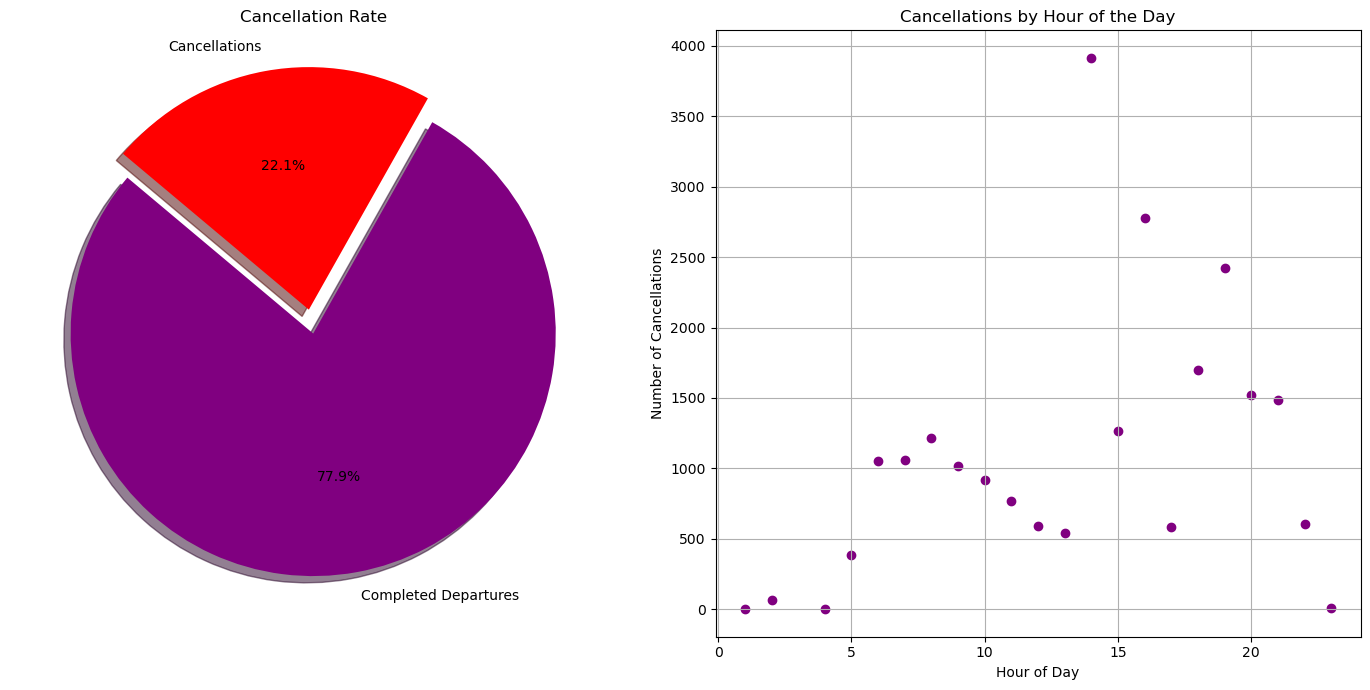

In [35]:
# Define sizes & labels
sizes = [total_planned - num_cancellations, num_cancellations]
labels = ['Completed Departures', 'Cancellations']
colors = ['purple', 'red']
# Explode the cancellations slice
explode = (0, 0.1)  

plt.figure(figsize=(14, 7))

# Pie chart of cancellations
plt.subplot(1, 2, 1)
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Cancellation Rate')

# Line graph of cancellations by hour of the day
cancellations_by_hour = cancellations.groupby('planned_dep_hour').size()
plt.subplot(1, 2, 2)
plt.scatter(cancellations_by_hour.index, cancellations_by_hour.values, color='purple')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Cancellations')
plt.title('Cancellations by Hour of the Day')
plt.grid(True)
plt.tight_layout()
plt.show()

**Correlation: Hour of the Day vs Cancellations**

In [ ]:
# Calculate correlation between actual departure hour and cancellation

# create binary column to identify delay (1 or 0)
pandas_df['is_canceled'] = (pandas_df['actual_arrival_time'].isna() | pandas_df['actual_departure_time'].isna()).astype(int)

# Calculate correlation
delay_correlation = pandas_df[['actual_dep_hour', 'is_canceled']].corr().iloc[0, 1]

In [37]:
print(f'Correlation between hour of the day & cancellation: {delay_correlation}')

Correlation between hour of the day & cancellation: -0.016449391208166197


## Analysis 2 Conclusion

Upon initial inspection of the above "Cancellation by Hour of Day" scatter plot and the "Distribution of Train Departures by Hour" from Analysis 1, it appears that train cancellations are correlated with the hour of the day.

The scatter plot shows that train cancellations are more frequent during the afternoon and evening hours. Similarly, the "Distribution of Train Departures by Hour" indicates that most departures occur in the afternoon and evening.

However, further calculations show there is almost no correlation between the two. While one might infer that the noticeable spike in train cancellations from 2pm-5pm may be due to an increased demand in departures, the data does not support a strong correlation. 

To better understand the causes of train cancellations, additional data is required. Factors such as foot traffic in the station, weather conditions, and maintenance schedules might be more reliable predictors of cancellations.


## Analysis 3
## Do The Most Popular Stations Also Have The Most Delays?

**Top 10 Most Frequently Visited Stations**

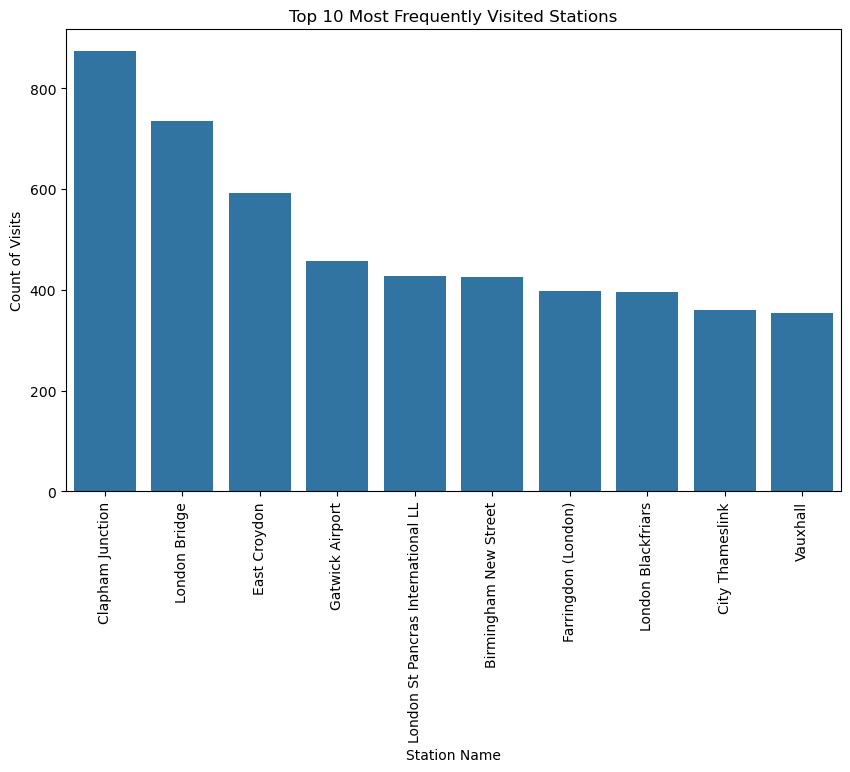

In [38]:
top_10_stations = pandas_df['StationName'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_stations.index, y=top_10_stations.values)
plt.title('Top 10 Most Frequently Visited Stations')
plt.xlabel('Station Name')
plt.ylabel('Count of Visits')
plt.xticks(rotation=90)
plt.show()

Clapham Junction is the most frequently visited station. As a major transport hub, it houses connections to popular rail lines including South Western Railway, Southern, and London Overground, as well as access to major destinations such as Gatwick Airport, London Waterloo, and London Victoria. Clapham services densely populated residential areas in South West London and is in close proximity to business and commercial districts, contributing to the high passenger demand.

**Top 10 Stations with Highest Delays**

In [40]:
# Calculate the total delay time per station
total_delay_time = delayed_df.groupby('StationName')['dep_time_delayed_by(min)'].sum().reset_index()

# Calculate the count of delayed departures per station
delayed_deps = delayed_df[delayed_df['is_delayed_departure'] == True].groupby('StationName')['is_delayed_departure'].count().reset_index()
delayed_deps = delayed_deps.sort_values(by='is_delayed_departure', ascending=False)

# Calculate average delays per station
avg_delay = delayed_df.groupby('StationName')['dep_time_delayed_by(min)'].mean().reset_index()
avg_delay = total_delay_time.sort_values(by='dep_time_delayed_by(min)', ascending=False)

# Merge into a single DataFrame
result = pd.merge(delayed_deps, total_delay_time, on='StationName')

# Sort by count of delayed departures
result = result.sort_values(by='is_delayed_departure', ascending=False)

result.head(10)

,StationName,is_delayed_departure,dep_time_delayed_by(min)
0,Harlesden,107,7249.0
1,Willesden Junction Low Level,107,7249.0
2,Cardiff Queen Street,101,3826.0
3,Sunderland,84,5484.0
4,Cardiff Central,80,4029.0
5,Trefforest,78,3527.0
6,Pontypridd,78,3611.0
7,Trefforest Estate,77,2079.0
8,Radyr,77,2086.0
9,Taffs Well,77,2078.0


## Analysis 3 Conlusion

There is no overlap in the top 10 most frequently visited stations and stations with the highest delays. 
This is a positive outcome, as it indicates the most popular train stations maintain higher operational efficiency to mitigate delays. 

**Possible reasons for the highest delays in the top 3 stations:**

**Harlesden**: served by the popular Bakerloo Line and London Overground, Harlesdon can be affected by that influx of passengers. As an older station, Harlesden may require more frequent maintenance work.

**Willesdon**: served by the Jubilee Line, Bakerloo Line, and London Overground. The high traffic and the need for coordination between different rail services can cause delays, as well as train scheduling and platform availability between London Underground and Overground.

**Cardiff**: a major hub for both local and long-distance trains. These trains can take a high volume of passengers. During events at the Principality Stadium, the station may have higher delays due to the influx of passengers.

**Other delay factors**:
- Economy
- Population
- Poverty
- Crime
- Lifestyle/amenities of the area

## Analysis 4
## Can We Predict If & How Long a Train Will be Delayed Based on Its Station?

The following correlation analyses will help us understand the relationship between train delays and respective stations

**Delay Correlation Analysis**

In [39]:
# Analyze correlations between features and delay columns
correlation_matrix = pandas_df.corr(numeric_only=True)
# Display the correlations with delay columns
delay_correlations = correlation_matrix[['arrival_time_delayed_by(min)', 'dep_time_delayed_by(min)', 'planned_arrival_hour', 'actual_arrival_hour','planned_dep_hour', 'actual_dep_hour']].sort_values(by='dep_time_delayed_by(min)', ascending=False)

delay_correlations.head()

,arrival_time_delayed_by(min),dep_time_delayed_by(min),planned_arrival_hour,actual_arrival_hour,planned_dep_hour,actual_dep_hour
dep_time_delayed_by(min),0.999717,1.000000,-0.040839,0.081077,-0.040777,0.082099
arrival_time_delayed_by(min),1.000000,0.999717,-0.041752,0.080599,-0.041628,0.080655
is_delayed_arrival,0.175573,0.165746,0.017651,0.027993,0.017609,0.027837
is_delayed_departure,0.175646,0.161006,0.015739,0.028164,0.015725,0.024931
actual_dep_hour,0.080655,0.082099,0.991087,0.999517,0.991497,1.000000


While arrival and delay have the strongest correlation, that is anticipated, as if a train was arriving late, it would likely be departing late as well. Our focus is on the positive correlation between whether a train is delayed and its arrival or departure times, suggesting that these delays are somewhat predictable based on the time of day.

**Visualize: Correlation Heat Map**

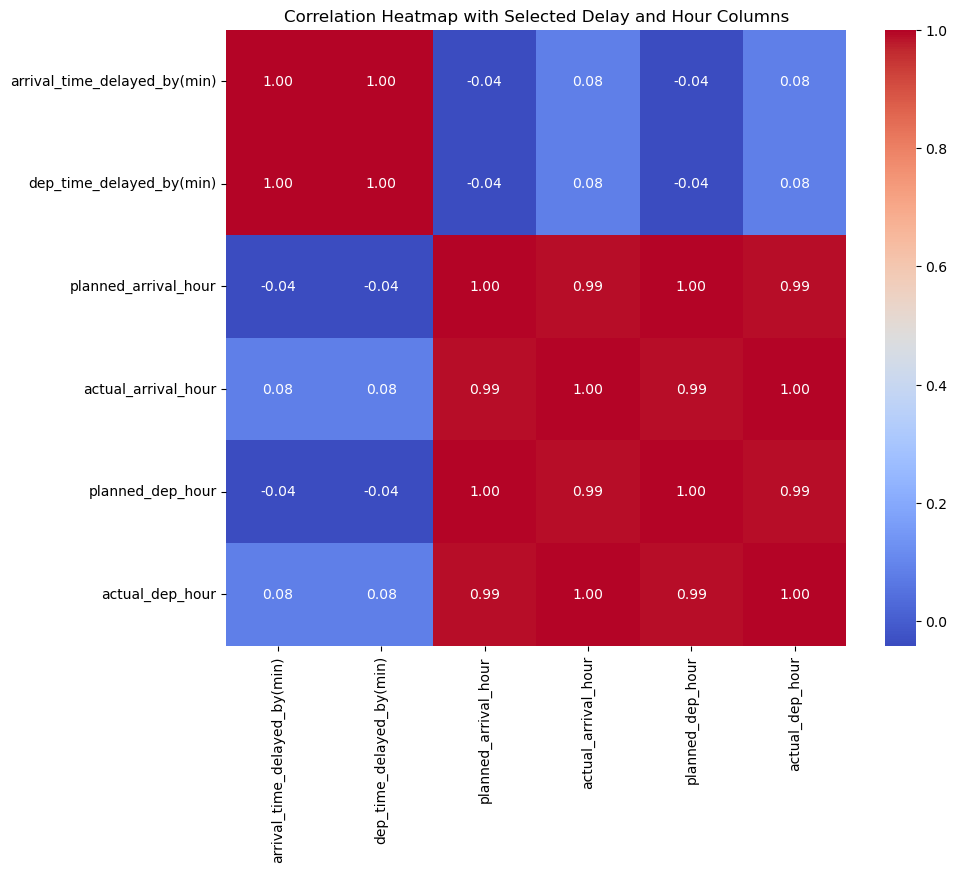

In [45]:
# Select columns to compare
selected_columns = ['arrival_time_delayed_by(min)', 'dep_time_delayed_by(min)', 
                     'planned_arrival_hour', 'actual_arrival_hour', 
                     'planned_dep_hour', 'actual_dep_hour']

delay_correlations = correlation_matrix.loc[selected_columns, selected_columns]

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(delay_correlations, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap with Selected Delay and Hour Columns')
plt.show()


## Logistic Regression
The following results were calculated on GoogleColab due to data size

In [ ]:
# logistic regression:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Select relevant columns and drop null rows
vars = pandas_df[['train_platform', 'planned_arrival_hour', 'planned_dep_hour', 'is_delayed_departure']].dropna()

# Convert booleans to floats
vars['is_delayed_departure'] = vars['is_delayed_departure'].astype('float')
vars['planned_dep_hour'] = vars['planned_dep_hour'].astype('float')

# One-hot encoding for the categorical 'platform' column
vars = pd.get_dummies(vars, columns=['train_platform'], dtype='float')

# X = all columns except 'is_delayed_departure'
X = vars.drop('is_delayed_departure', axis=1)
y = vars['is_delayed_departure']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Model
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train, y_train)

In [ ]:
# Evaluate Model
y_pred = log_reg.predict(X_test)

# Define report, confusion matrix, and accuracy
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Display results
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)
print("Confusion Matrix:\n", cm)

**Accuracy**: 92.9%

- True Negatives: 30138 (Predicted 0, actual 0)
- False Positives: 88 (Predicted 1, actual 0)
- False Negatives: 2229 (Predicted 0, actual 1)
- True Positives: 58 (Predicted 1, actual 1)
  actual 1)

**Performance on Delayed:**

- Precision: 40% of Delay predictions were correct
- Recall: 3% of Not Delayed were correctly identified

**Performance on Not Delayed:**

- Precision: 93% of Not Delayed instances were correct
- Recall: 100% of trains Not Delayed were correctly identified

While a high accuracy is generally good, given the low instances of 0 (Not Delayed), the dataset appears to be highly imbalanced, impacting the model's ability to correctly identify delays.

This model is stronger at predicting when a train will not be delayed, than if it will be delayed. If a delay is predicted, there is a 40% chance that the train will actually be delayed.

When prospective passengers check train schedules, it is better to incorrectly predict a delay rather than no delay to allow them time to adjust their plans. An unfavorable case may be: if a passenger is behind schedule and a delay is incorrectly predicted, they might unnecessarily change their plans.

Over-predicting delays may cause unnecessary inconvenience and under-predicting them can leave passengers unprepared, resulting in significant disruptions to their plans.

## Overall Review

The scheduling of more or fewer trains at certain times is influenced by passenger demand, operational efficiency, maintenance needs, geographical, and demographic factors. By identifying the business's strong suits, trains can run efficiently and reliably service while managing costs and maximizing customer satisfaction.

**Reccomendations**:
- Identify causes of cancellations and work to reduce the rate around peak hours, especially in the evening.
- Increase train frequency between 4 PM and 7 PM to accommodate evening rush hour, night shift workers, and evening events
- Identify factors contributing to the high volume of train departures and delays on Tuesdays
- Use the morning dead hours for maintenance fixes
- Analyze outside causes for delay effects, such as weather, station foot traffic, and local events

**Sources**

https://www.nationalrail.co.uk/
https://en.wikipedia.org/wiki/Harlesden
https://www.norfolkinsight.org.uk/population/#/view-report/63aeddf1d7fc44b8b4dffcd868e84eac/___iaFirstFeature/G3
https://en.wikipedia.org/wiki/Willesden
https://data.brent.gov.uk/
https://en.wikipedia.org/wiki/Cardiff_Central_railway_station

## Export DataFrame to PowerBi for Further Visualizations

In [36]:
# pandas_df.to_csv('rail_data_eda.csv', index=False)